In [1]:
# this code gets only the images to trian the pre-trained model using the cross validation technique

# use this cell to import all necessary libraries

import os
# to run on GPU, comment the following tow lines 
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import pylab
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from util_pre import read_data
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import random

Using TensorFlow backend.


In [3]:
# use this cell to get all of the input parameters and paths to train and tune

# input parameters and paths for training

csvPath = '/home/mohammadali/Downloads/Run/Train.csv'
imagePath = '/home/mohammadali/Downloads/Run/Train-Seg-Man'
inputSize = (224,224)
k_fold = 10
batch_size = 32
learning_rate = 1e-6
epoch_size = 3
nodes = 1024 # number of nodes for the fc layer
drop_out = 0.1 # the layer after the fc layer

# input parameters and paths for testing

test_dir = '/home/mohammadali/Downloads/Run/Test-Seg-Man'
csvTest = '/home/mohammadali/Downloads/Run/Test.csv'
IMG_SIZE = 224 

In [4]:
# use this cell to train the model (all of the inputs have been given in the second cell)

# preparing the data to train

random.seed(7)

train_img,train_label,val_img,val_label = read_data(csvPath,
        imagePath, inputSize, 0.00001, split_by_id=False, normalize=True, crop_image=True)
train_img = np.stack( (train_img[:,:,:,0],)*3, axis=-1 )
X = train_img
y = train_label

print("")
print("using images")
print("")
print("train_images:", train_img.shape)
print("train_labels:", train_label.shape)
#print("validation_images:", val_img.shape)
#print("validation_label:", val_label.shape)

# using the pretrained model for training

print("")
print("getting the model")
print("")
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    #conv_base.summary()

for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
#for layer in conv_base.layers:
#    print(layer, layer.trainable)

# making the FC layers of the model

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(nodes, activation='relu'))
model.add(layers.Dropout(drop_out))
model.add(layers.Dense(1, activation='sigmoid'))
#model.summary()

# compiling the model

model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=learning_rate), metrics=['acc'])

# defining k-fold cross validation test harness

kfold = StratifiedKFold(n_splits = k_fold, shuffle = True, random_state = np.random.seed(7))
cvscores1 = []
cvscores2 = []
i = 1
for train, test in kfold.split(X, y):
    
    # data augmentation

    train_datagen = ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

    #val_datagen = ImageDataGenerator(rescale=1./255)

    # training the model

    print('fold %d:' % (i))
    batch_size = batch_size
    H = model.fit_generator(
        train_datagen.flow(X[train], y[train], batch_size = batch_size),
        steps_per_epoch=len(X[train]) // batch_size,
        epochs=epoch_size,
        validation_data=(X[test], y[test]),
        validation_steps=len(X[test]) // batch_size)

    # computing the accuracy metric for this CV fold
    
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores1.append(scores[1] * 100)
    
    # computing the AUC metric for this CV fold

    preds = model.predict(X[test])
    fpr, tpr, thresholds = metrics.roc_curve(y[test], preds)
    roc_auc = metrics.auc(fpr, tpr)
    print("%s: %.2f%%" % ('auc', roc_auc*100));
    cvscores2.append(roc_auc*100)
    i = i + 1
    print('');

print("tot_acc_avg: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores1), np.std(cvscores1)));
print("tot_auc_avg: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores2), np.std(cvscores2)));

# saving the model

model.save_weights('model_weights_lung_pro_cv_image.h5')
model.save('model_lung_pro_cv_image.h5')

Labels loaded: 50 positive,45 negatve.
Split dataset according to images. Training : 564 images; Validation: 6 images.

using images

train_images: (564, 224, 224, 3)
train_labels: (564,)

getting the model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
fold 1:
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
15/15 [==============================] - 5s 364ms/step - loss: 0.7479 - acc: 0.4750 - val_loss: 0.7329 - val_acc: 0.4912
Epoch 2/3
15/15 [==============================] - 2s 165ms/step - loss: 0.7162 - acc: 0.5068 - val_loss: 0.7220 - val_acc: 0.4737
Epoch 3/3
15/15 [==============================] - 3s 222ms/step - loss: 0.7168 - acc: 0.5099 - val_loss: 0.7077 - val_acc: 0.5263
acc: 52.63%
auc: 49.14%

fold 2:
Epoch 1/3
15/15 [==============================] - 4s 254ms/step - loss: 0.6968 - acc: 0.5542 - val_loss: 0.7011 - val_acc:

shape of X_test: (21, 224, 224, 3)
shape of y_test: (21,)
21/21 [==============================] - 1s 28ms/step

Predicted labels: [1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1]

True labels: [0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0]

[False  True False  True  True  True  True False  True False  True  True
  True False False  True False False False False False]


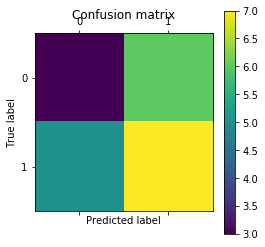

In [5]:
# use this cell to test the model (all of the inputs have been given in the second cell)

# loading the model

#model = load_model('model_lung_pro_cv_image.h5')
#model.summary()

# getting the images for testing

file_list2 = os.listdir(test_dir)
test_imgs = [test_dir + "/" + "{}".format(i) for i in file_list2]
#print("No. of test images = ", len(test_imgs))
X_test = []
for image in test_imgs:
    X_test.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC))

X_test = np.array(X_test)
X_test = (X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))
#X_test = X_test/255.0
print("shape of X_test:", X_test.shape)

df = pandas.read_csv(csvTest)
#print('shape of the dataframe:', df.shape)
#print(df.head(2))

# getting the true labels for testing

na = df.loc[:,'File']
la = df.loc[:,'Progression']
na = np.array(na)
la = np.array(la)
I = np.argsort(na)
na = na[I]
la = la[I]
y_test = la
#sns.set(rc={'figure.figsize':(5,4)})
#sns.countplot (y_test)
#plt.title("Labels")
print ("shape of y_test:", y_test.shape)

# model prediction

preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
predictions_test = preds_test_t [:, 0]
print("")
print("Predicted labels:", predictions_test)
print("")
print("True labels:", y_test)
print("")
com = np.isclose(predictions_test, y_test.T)
print (com)
#true_prediction_number = 1 * (com == 'True')
#print(true_prediction_number)
cm = confusion_matrix(y_test, predictions_test)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()